# Approximated TSP Algorithms

**Task**: Implementation of Christophides approximation algorithm for simple hexagon and then on metric-Travelling saleperson problem on the provided data.

## Christophides algorithm
___
**Input** Graph $G=(V,E)$; cost function $c:E\rightarrow \mathbb{N}^+$ satistying triangle inequality.<br/>
1. $T :=$ Construct a minimal spanning tree $T$ of $G$ according to $c$. <br/>
2. $O := \{v\in V | \mathrm{d}_T(v) $ is odd.\}<br/>
3. $M :=$ Construct minimum weight perfect matching $M$ on $O$ in $G$.<br/>
4. $A :=$ Construct multigraph $G'=(V,E(T\cup M))$ in $G'$. <br/>
5. $T':=$ Construct an Eulerian tour $T'$ in $A$ (all degrees are even). <br/>
5. $O' :=$ Construct a Hamiltonian tour $O'$ of $G$ by shortening $T'$ (i.e. by removing all repetitions of the occurances of every vertex in $T'$ in one run via $T'$ from left to right. <br/>

**Output** $O'$
___


## Packages you might need

In [40]:
import pandas as pd, numpy as np
from random import shuffle

# For precomputing distances
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
%matplotlib inline

## Simple example: Hexagon

Before running Christophides algorithm on travelling salesman problem, try it out on a simpler problem.<br>
Following is how I constructed a simple hexagon on unit circle.<br>
You are free to design your own solution.

In [41]:
labels = ['node_ID', 'x', 'y']

c1 = np.cos(np.pi/6)
s1 = np.sin(np.pi/6)

points = [('0',0,1),
          ('1',-c1, s1),
          ('2',-c1, -s1),
          ('3',0, -1),
          ('4',c1, -s1),
          ('5',c1, s1)]

In [42]:
node_data = pd.DataFrame.from_records(points, columns=labels)
display(node_data)

,node_ID,x,y
0,0,0.000000,1.0
1,1,-0.866025,0.5
2,2,-0.866025,-0.5
3,3,0.000000,-1.0
4,4,0.866025,-0.5
5,5,0.866025,0.5


In [43]:
def show_tour(data, path=None):

    x = data.x
    y = data.y
    labels = data.node_ID
    
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    ax.axis('equal')
    for i in range(len(labels)):
        ax.annotate(labels[i], (x[i], y[i]))

    ax.scatter(x,y,c='r',edgecolors='b')
    plt.axis('off')
    if path is not None:
        ax.plot(x[path], y[path], linewidth=3)
        
    # plt.savefig('hexagon_graph.png', format='png')
    plt.show()

In [44]:
# Just a random path for visualization
hamil_path = list(range(0, node_data.shape[0]))
shuffle(hamil_path)
hamil_path.append(hamil_path[0])

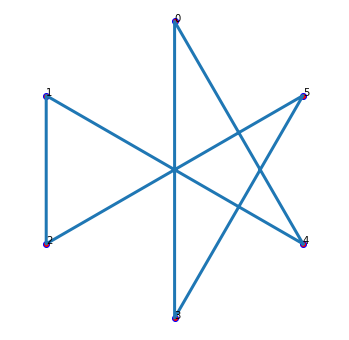

In [45]:
show_tour(node_data, path=hamil_path)

### Build a graph
Graph consists of:
+ nodes
+ distance between nodes

In [46]:
import networkx as nx
import itertools
import math

def build_graph(indata: pd.DataFrame) -> nx.Graph:
    data = indata.copy()
    data.columns=['node_ID','x','y']
    G = nx.Graph()
    G.add_nodes_from([node for node in data.iloc[:,0]])
    for a,b in itertools.combinations(list(G.nodes),2):
        coordinates_a = (data.loc[data['node_ID'] == a].iloc[:,1].values[0],data.loc[data['node_ID'] == a].iloc[:,2].values[0])
        coordinated_b = (data.loc[data['node_ID'] == b].iloc[:,1].values[0],data.loc[data['node_ID'] == b].iloc[:,2].values[0])
        G.add_edge(a,b,length = math.sqrt((abs(coordinates_a[0]-coordinated_b[0]))**2+(abs(coordinates_a[1]-coordinated_b[1]))**2))
    return G

def build_path(G: nx.Graph)-> list:
    return

### Build minimal spanning tree

In [47]:
def prim(G: nx.Graph)-> nx.Graph:
    T = nx.Graph()
    u = list(G.nodes)[0]
    U = {u}
    while U != set(G.nodes):
        new_edge = min([(a,b,G.get_edge_data(a,b)['length'])for a,b in itertools.product(U,set(G.nodes).difference(U))],key= lambda tup: tup[2])
        T.add_edge(new_edge[0], new_edge[1],length=new_edge[2])
        U.add(new_edge[1])
    return T


### Find odd vertices

In [48]:
def odd_vertices(G: nx.Graph)-> list:
    O =[]
    for node in list(G.nodes):
        if (len(list(G.neighbors(node))) % 2) != 0:
            O.append(node)
    return O

### Add minimum weight matching edges to minimum spanning tree

In [49]:
def min_weight_match(G:nx.Graph):
    matching = nx.min_weight_matching(G,weight='length')
    M = nx.Graph()
    for edge in matching:
        M.add_edge(edge[0], edge[1], length=G.get_edge_data(edge[0],edge[1])['length'])
    return M


### Find Eulerian tour

In [50]:
def hierholzer(G: nx.MultiGraph)-> list:
    B = nx.eulerian_circuit(G)
    walk = [tup[0] for tup in list(B)]
    walk.append(walk[0])
    return walk
        
def inorder_walk(G: nx.MultiGraph):
    pass


### Construct Hamiltonian circuit by skipping repeated vertices

In [51]:
def hamilton(walk):
    hamil = []
    for item in walk:
        if not item in hamil:
            hamil.append(item)
        else:
            continue
    hamil.append(hamil[0])    
    return hamil

## A2TSP

In [52]:
def a2tsp(daten: pd.DataFrame):
    G = build_graph(daten)
    T = prim(G)
    A = nx.MultiGraph(list(T.edges)+(list(T.edges)))
    euler_kreis = hierholzer(A)
    hamil_kreis = hamilton(euler_kreis)
    return hamil_kreis

## Christofides algorithm

In [53]:
def christofides(daten: pd.DataFrame):    
    G = build_graph(daten)
    T = prim(G)
    M = min_weight_match(G.subgraph(odd_vertices(T)))
    A = nx.MultiGraph(list(T.edges)+(list(M.edges)))
    euler_kreis = hierholzer(A)
    hamil_kreis = hamilton(euler_kreis)
    return hamil_kreis

## Calculating costs of a tour

In [54]:
def tsp_length(tour: list, nodes: pd.DataFrame): #tournames have to equal node names
    G = build_graph(nodes)
    length = 0.0
    for i in range(1,len(tour)):
        length += G.get_edge_data(tour[i-1],tour[i])['length']
    return length

## Travelling Salesman Problem (TSP)

In [55]:
from imageio.v2 import imread
from skimage.transform import resize

### Loading data

In [56]:
# Load background Image
img = imread("world-map.jpg")
scale = 10 # multiplication factor for image scaling
img = resize(img, (scale*180,scale*360), mode='constant')

# Load data
df = pd.read_csv('25_cities.txt', sep=',')

In [57]:
display(df)

,cities,longitude,latitude
0,Shanghai,121.47,31.23
1,Bombay,72.82,18.96
2,Karachi,67.01,24.86
3,Buenos Aires,-58.37,-34.61
4,Delhi,77.21,28.67
5,Istanbul,29.00,41.10
6,Manila,120.97,14.62
7,Sao Paulo,-46.63,-23.53
8,Moscow,37.62,55.75
9,Dhaka,90.39,23.70


### Visualization

In [58]:
def view_tsp_tour(df, bg_img, title_str='TSP (nodes approximately positioned)', path=None,
                  save_fig=False, file_name='tsp_chistophides'):
    cities = df.cities
    latitudes  = scale * (df.latitude - 15) # offset so that coords to match in image
    longitudes = scale * (df.longitude - 1)
    
    fig, ax = plt.subplots(1,1,figsize=(18,9))
    ax.scatter(longitudes, latitudes, c = 'r')        # Nodes
    
    # Tour
    if path is not None:
        ax.plot(longitudes[path], latitudes[path])
    
    # Background
    plt.imshow(bg_img, extent=[-bg_img.shape[1]/2., bg_img.shape[1]/2.,\
                               -bg_img.shape[0]/2., bg_img.shape[0]/2.])
    
    # City labels
    for i in range(len(cities)):
        ax.annotate(cities[i], (longitudes[i], latitudes[i]))

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title_str)
    if save_fig:
        plt.savefig(file_name)
    plt.show()
    plt.close

### Christophides approximation of TSP

In [59]:
coords = df[['longitude', 'latitude']].copy()

In [60]:
# h_path = christophides(coords)

In [61]:
# Just a random path for visualization
h_path = list(range(0, df.shape[0]))
shuffle(h_path)

#point from node names to node indexes for visualization
def build_path(lst, daten: pd.DataFrame):
    walk = [daten.loc[daten['cities'] == station].index[0] for station in lst]
    return walk

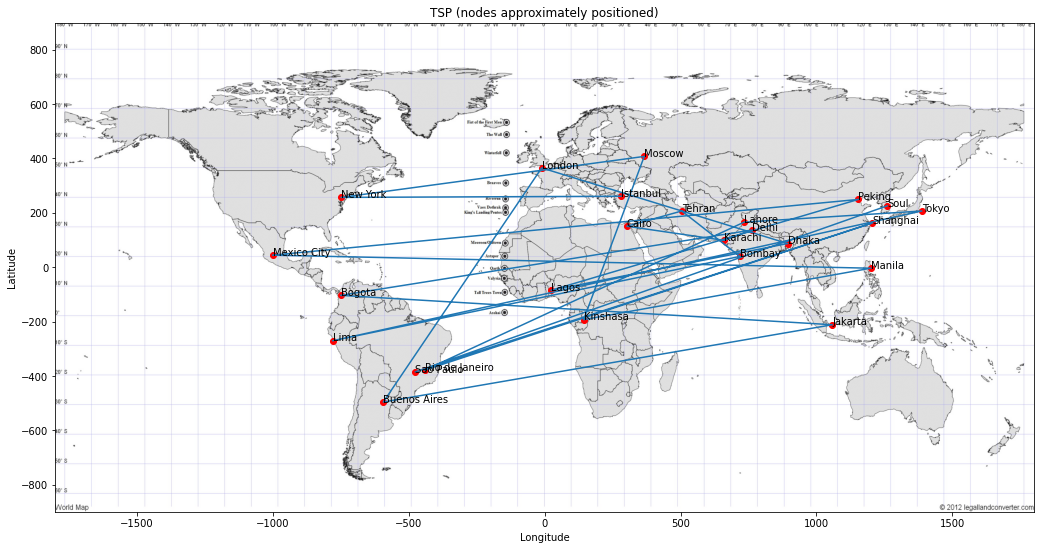

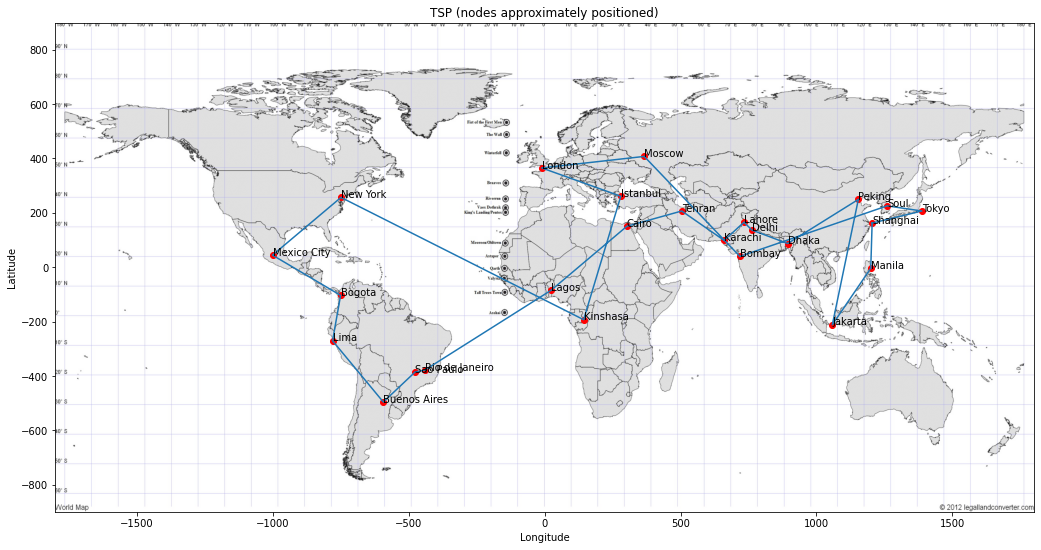

Length of tour calculated with A2TSP Algorithm 763.1983898902158


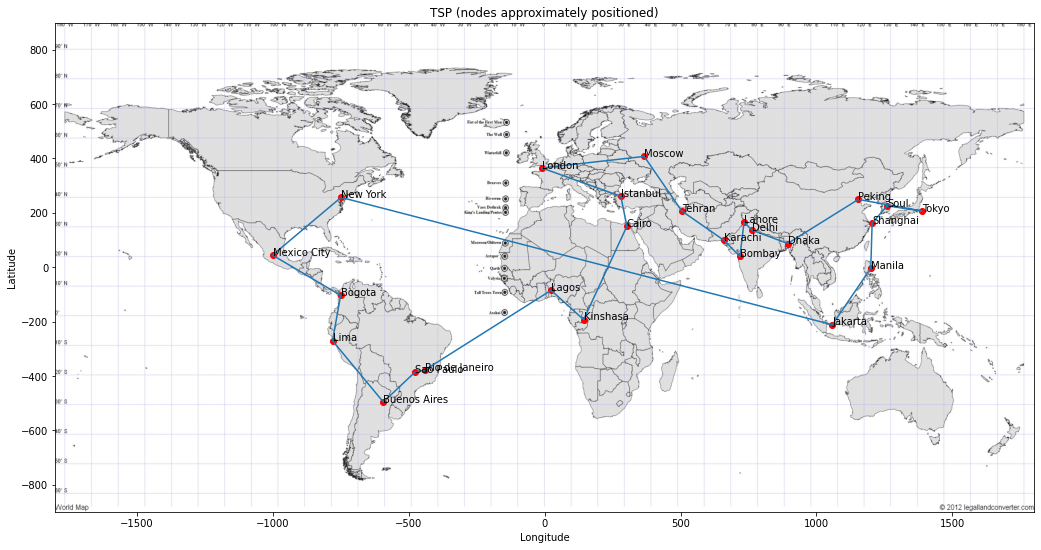

Length of tour calculated with Christofides Algorithm 703.822338182641


In [62]:
# Just some example tours
view_tsp_tour(df, img, path=h_path)

view_tsp_tour(df, img, path=build_path(a2tsp(df),df))
print(f'Length of tour calculated with A2TSP Algorithm {tsp_length(a2tsp(df),df)}')

view_tsp_tour(df, img, path=build_path(christofides(df),df))
print(f'Length of tour calculated with Christofides Algorithm {tsp_length(christofides(df),df)}')

This is how my solution looks like:
![](tsp_chistophides.png)
But I have seen implementations where students get better solutions for their Christophides implementation.<br>
Those who are doing ECTA, you certainly have seen better solutions. This is power of combining randomized algorithms with approximation schemas.